<a href="https://colab.research.google.com/github/v-zeng/python_projects/blob/main/tf_audio_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Deep Audio Classifier with Tensorflow
### Data from: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

In [2]:
# # 1. install dependencies
# !pip install Tensorflow-io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 19.8 MB/s eta 0:00:00


In [3]:
# load dependencies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [4]:
# define path to data files
capuchin_file = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
not_capuchin_file = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [5]:
not_capuchin_file

'/content/drive/MyDrive/python_projects_data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

In [6]:
# 2. create function to load data and convert to 16Hz mono channel
# code below references tensorflow docs
def load_wav_16k_mono(filename):
  # load encoded wav file
  file_contents = tf.io.read_file(filename)
  # decode wav, mono channel
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  # removes trailing axis, cast sample rate as 64 bit int for resampling
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # goes from 44100Hz to 16000Hz - amplitude of the audio signal
  # reduces amount of data processing required
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

In [7]:
# load the two waves defined in paths above
wave = load_wav_16k_mono(capuchin_file)
nwave = load_wav_16k_mono(not_capuchin_file)

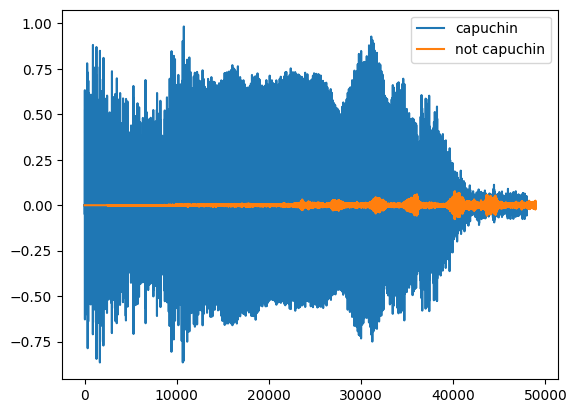

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.legend(['capuchin', 'not capuchin'])
plt.show()

In [9]:
# 3. Create Tensorflow Dataset
# define positive and negative data paths
POS = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Not_Capuchinbird_Clips')
# create Tensorflow format Dataset from any wav files
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [10]:
# inspect first item in iterator; check next filepath
pos.as_numpy_iterator().next()

b'/content/drive/MyDrive/python_projects_data/Parsed_Capuchinbird_Clips/XC433953-9.wav'

In [11]:
# label and combine samples accordingly, 1 for pos and 0 for neg
# note: pos (217) and neg (593) samples unbalanced, consider resample or undersample of neg
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [12]:
# shuffle combined data and check for binary label
for i in range(10):
  print((data.shuffle(500).as_numpy_iterator().next()[1]))

0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0


In [13]:
# 4. Determine mean event length (capuchin call)
# convert samples to 16kmono wav form
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips', file))
  lengths.append(len(tensor_wave))


In [14]:
# check filepath
print(os.listdir(os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips'))[1:50:10])


['XC114132-6.wav', 'XC114132-3.wav', 'XC114132-4.wav', 'XC16803-1.wav', 'XC216012-13.wav']


In [15]:
# check mean of parsed cap samples, calculate capuchin clip length mean

mean_length = tf.math.reduce_mean(lengths)/16000 # 54156
min_length = tf.math.reduce_min(lengths)/16000 # 32000
max_length = tf.math.reduce_max(lengths)/16000 # 80000
print(f'''
mean length: {mean_length}
min length: {min_length}
max length: {max_length}''')


mean length: 3.38475
min length: 2.0
max length: 5.0


In [30]:
# 5. Create function for converting data to spectrograms; preprocessing
def preprocess(file_path, label): # label will be passed through
  wav = load_wav_16k_mono(file_path) # convert data to desired wav form
  wav = wav[:48000] # use 48k sizing for each signal]
  # zero padding for sub-48k clips
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  # short-time Fourier transformation
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram) # convert to absolute values
  # add single channel for use with CNN
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [31]:
# test function
wav = load_wav_16k_mono(capuchin_file)
wav = wav[:48000] # use 48k sizing for each signal]
# zero padding for sub-48k clips
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav], 0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 8.9910554e-07, -2.7947258e-06,  7.0741157e-06, ...,
       -1.0823049e-02, -3.5766482e-03,  1.5143131e-02], dtype=float32)>

In [ ]:
# test function cont'd 1 - spectrogram conversion
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram) # convert to absolute values
spectrogram = tf.expand_dims(spectrogram, axis=2) # add single channel

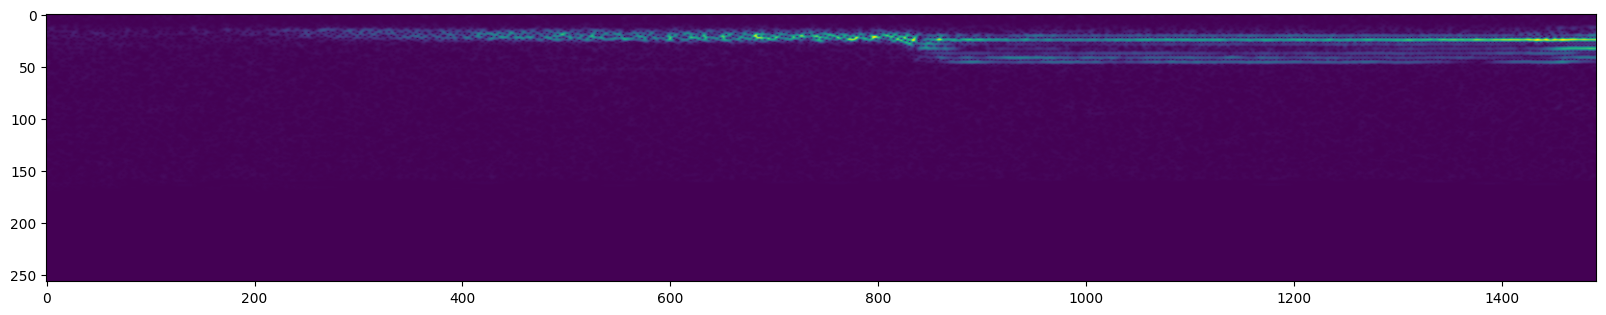

In [62]:
# test function cont'd 2 - view spectrogram
# get next positive example from pipeline
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(20,15))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

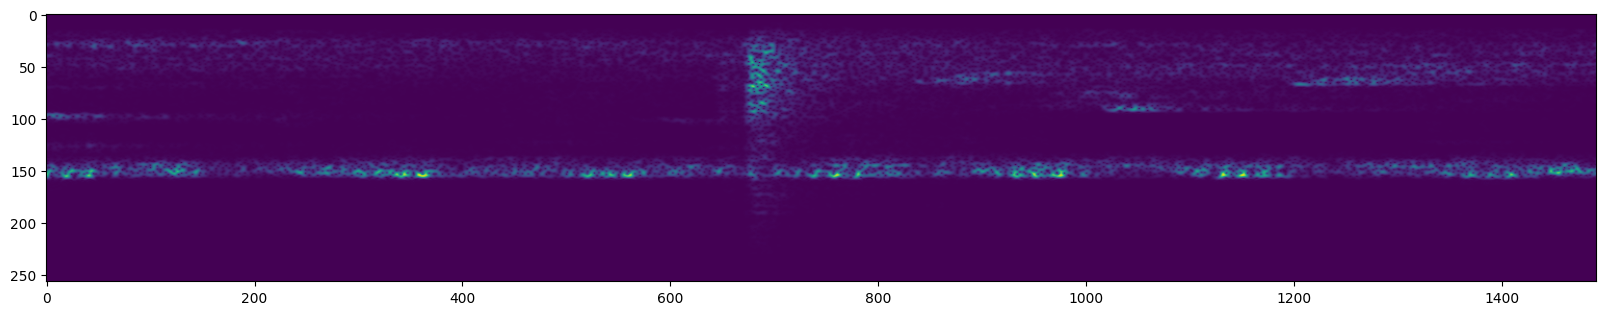

In [64]:
# take a look at negative example from pipeline
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(20,15))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [65]:
# 6. Train test partition
# create tensorflow data pipeline
data = data.map(preprocess) # map preprocess function across elements
data = data.cache() # cache elements in dataset
data = data.shuffle(buffer_size=1000) # random shuffle elements
data = data.batch(16) # combine elements, 16 samples per batch
data = data.prefetch(8) # prefetch 8 examples to mitigate bottlenecking